In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# dataset basic info

### About pima diabetes dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

#### Content:
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### loading dataset

In [ ]:
df=pd.read_csv('PIMA_diabetes.csv')
df

### Basic info 

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.hist(figsize=(20,10))
plt.show()

In [ ]:
fig , ax= plt.subplots(1,2, figsize=(23,10), dpi=100)

pearson=df.corr()
ax[0].set_title('pearson')
sns.heatmap(pearson, cmap='YlGnBu', square=True, annot=True, ax=ax[0])

spearman=df.corr(method='spearman')
ax[1].set_title('spearman')
sns.heatmap(spearman, cmap='YlGnBu', square=True, annot=True, ax=ax[1])

plt.show()

# FUNCTIONS to check outliers

#### 5 point summary fn

In [ ]:
def five_point(column):
    print('5 point summary:')
    print(pd.DataFrame(column).describe().iloc[3:] )
    print('---------------------------------')

#### Z score fn

In [ ]:
def z_score(column):
    
    mean=np.mean(column)
    stdev=np.std(column)
    
    with_z=pd.DataFrame( {
                            'outliers' : column,
                            'Z-score' : (column-mean)/stdev 
    })
    
    lower=-3*stdev+mean
    upper=3*stdev+mean
    
    print( 'OUTLIERS in '+column.name.upper()+' via Z score\n' )
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)
    print()
    
    outliers=with_z[ abs( with_z['Z-score'] )>3 ]          # observations with absolute value of z-score greater than 3 are considered outliers
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')

#### IQR fn

In [ ]:
def IQR_method(column):
    
    print( 'OUTLIERS in '+column.name.upper()+' via IQR\n' )
    
    #extracting q1,q3 from df.describe
    q1,q3=column.describe().iloc[[4,6]]
    
    #upper and lower limit using iqr
    iqr=q3-q1
    upper=q3+1.5*iqr
    lower=q1-1.5*iqr
    
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)            # outlier limits defined using quartiles, iqr and tukey value of 1.5
    print()
    
    outliers=pd.DataFrame( {
                            'outliers' : column[(column<lower) | (column>upper) ]
    })
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')
    

#### Analysis of quantitative columns fn

In [ ]:
def analysis_quant(column):
    print('\t\t\t\tANALYSIS OF:',column.name.upper(),'\n')

    five_point(column)      # five point summary
    z_score(column)         # z score and outliers
    IQR_method(column)      # iqr and outliers using boxplot
    
    print('\t\t\t\t\t\t\t\t\t\tVISUALISATION\n\t\t\t\tBOXPLOT\t\t\t\t\t\t\t\t\t\t\t\tHISTOGRAM')
    
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,7),dpi=300)
    sns.boxplot(ax=axes[0] , x=column)                       # boxplot
    sns.histplot(ax=axes[1],data=column,bins=25)             # histogram
    plt.show()
    
    print('_____________________________________________________________________________________________________________________')

#### Remove outliers fn

In [ ]:
def remove_outliers(df,column,using='IQR'):
    
    '''Remove outliers from dataframe by using either IQR or Z
       Parameters: df: a pandas dataframe
                   column: column(name) from which outliers are to be removed
                   using: by default 'IQR' is used. Other option is 'Z'
    '''
    
    if using.upper()=='IQR':
        
        #extracting q1,q3 from df.describe
        q1,q3=df[column].describe().iloc[[4,6]]

        #upper and lower limit using iqr
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        
        outliers=pd.DataFrame( { 'outliers' : df[column][(df[column]<lower) | (df[column]>upper)] } )
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)
        
        
    if using.upper()=='Z':
        
        mean=np.mean(df[column])
        stdev=np.std(df[column])

        with_z=pd.DataFrame( {'outliers' : df[column], 'Z-score' : (df[column]-mean)/stdev  })

        lower=-3*stdev+mean
        upper=3*stdev+mean

        outliers=with_z[ abs( with_z['Z-score'] )>3 ]
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)


# SCALING

# Model without outlier removal

##### Separating features and label

In [ ]:
X=df.drop('Outcome',axis=1)
y=df.Outcome
X

In [ ]:
y

##### train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=5)

### 1 LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,classification_report,precision_score,recall_score,confusion_matrix

In [ ]:
logistic_model=LogisticRegression(max_iter=100000, class_weight='balanced') # use solver like 'sag' or 'sagg'

logistic_model.fit(xTrain,yTrain)  

f1_score( logistic_model.predict(xTrain), yTrain)

In [ ]:
yPred=logistic_model.predict(xTest)

print('accuracy:       ',logistic_model.score(xTest,yTest))
print('f1 score:       ',f1_score(yTest, yPred) )
print('precision score:',precision_score(yTest,yPred))
print('recall score:   ',recall_score(yTest,yPred))
print('\nclassification report:\n',classification_report(yTest, yPred))
print('\nconfusion matrix:\n',confusion_matrix(yTest, yPred ))

### 2 DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [ ]:
model=DTC(max_depth=5,  criterion='entropy')   #min_impurity_decrease=0.1) #,

model.fit(xTrain,yTrain)

model.score(xTrain,yTrain)

In [ ]:
model.score(xTest,yTest)

### 3 RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [ ]:
model=RFC(n_estimators=300,  max_samples=.5, n_jobs=-1, class_weight='balanced')   

model.fit(xTrain,yTrain)

model.score(xTrain,yTrain)

In [ ]:
model.score(xTest,yTest)

In [ ]:
yPred=model.predict(xTest)
print(classification_report(yTest, yPred))

### 4 GRADBOOST

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [ ]:
model=GBC(n_estimators=500, learning_rate=.1, max_depth=7, max_features=3)

model.fit(xTrain, yTrain)

model.score(xTrain, yTrain),model.score(xTest,yTest)

In [ ]:
model.feature_importances_

### 5 XGB

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model=XGBClassifier(n_estimators=50000, learning_rate=.0008, n_jobs=-1)   

model.fit(xTrain,yTrain)

model.score(xTrain,yTrain)

In [ ]:
model.score(xTest,yTest)

### 6 ADABOOST CLASSIFIER

In [ ]:
from sklearn.ensemble import AdaBoostClassifier as ABC

In [ ]:
''' DT as base'''
model=ABC(base_estimator=DTC(max_depth=10), n_estimators=100, learning_rate=0.1)

model.fit(xTrain, yTrain)

model.score(xTrain, yTrain),model.score(xTest,yTest)

In [ ]:
model.feature_importances_

In [ ]:
''' RF as base'''
RF_=RFC(n_estimators=50, n_jobs=-1, max_depth=7)

model=ABC(base_estimator=RF_, n_estimators=100, learning_rate=0.1)

model.fit(xTrain, yTrain)

model.score(xTrain, yTrain),model.score(xTest,yTest)

In [ ]:
model.feature_importances_

### 7 SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(kernel='poly', degree = 4, C=100, gamma=10)
model.fit(xTrain, yTrain)

In [ ]:
model.score(xTest, yTest)

In [ ]:
model.score(xTrain,yTrain)

### 8 KNC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNC

In [ ]:
model=KNC(n_neighbors=5)
model.fit(xTrain, yTrain)

In [ ]:
model.score(xTest, yTest)

### 9 RNC

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier as RNC

In [ ]:
model=RNC(radius=10000)
model.fit(xTrain, yTrain)

In [ ]:
model.score(xTest, yTest)

# outlier removal

In [ ]:
''' removing only 1 absurd outlier:99'''
#remove_outliers(df,'SkinThickness',using='Z')

In [ ]:
'''removing outliers with value of 0 as glucose level and blood pressure and BMI'''
# remove_outliers(df,'Glucose',using='Z')
# remove_outliers(df,'BloodPressure',using='Z')
# remove_outliers(df,'BMI',using='Z')

## Analysis of outliers

#### Outliers

In [ ]:
# for col in df.columns:
#     analysis_quant(df[col])

## Model with outlier removal

### extract probability method

In [ ]:
pred_proba_df = pd.DataFrame(model.predict_proba(x_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

### plot auc roc method

In [ ]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y=log.predict(test_x) 

# probs_y is a 2-D array of probability of being labeled as 0 (first column of  array) vs 1 (2nd column in array)
probs_y=log.predict_proba(test_x) 

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_y, probs_y[:,1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

# Expt

In [24]:
mms_new=MinMaxScaler(feature_range=(10,20))

In [25]:
X=df.drop('target', axis=1)
y=df.target

In [26]:
def plotit():
    g = sns.FacetGrid(X.melt(), col='variable', col_wrap=2, aspect=3)
    g.map(plt.hist, 'value')
    g.fig.dpi=100
    plt.show()

In [27]:
def manipulate():
    for col in X.columns: #['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']:
        X[col]=np.log(X[col]+1)

In [28]:
def scale():
    global X
    cols=X.columns
    X=pd.DataFrame( mms_new.fit_transform(X), columns=cols)

In [29]:
def SPMP():
    X=df.drop('target', axis=1)
    y=df.target

    scale()
    plotit()
    
    manipulate()
    print('\n\n')
    plotit()

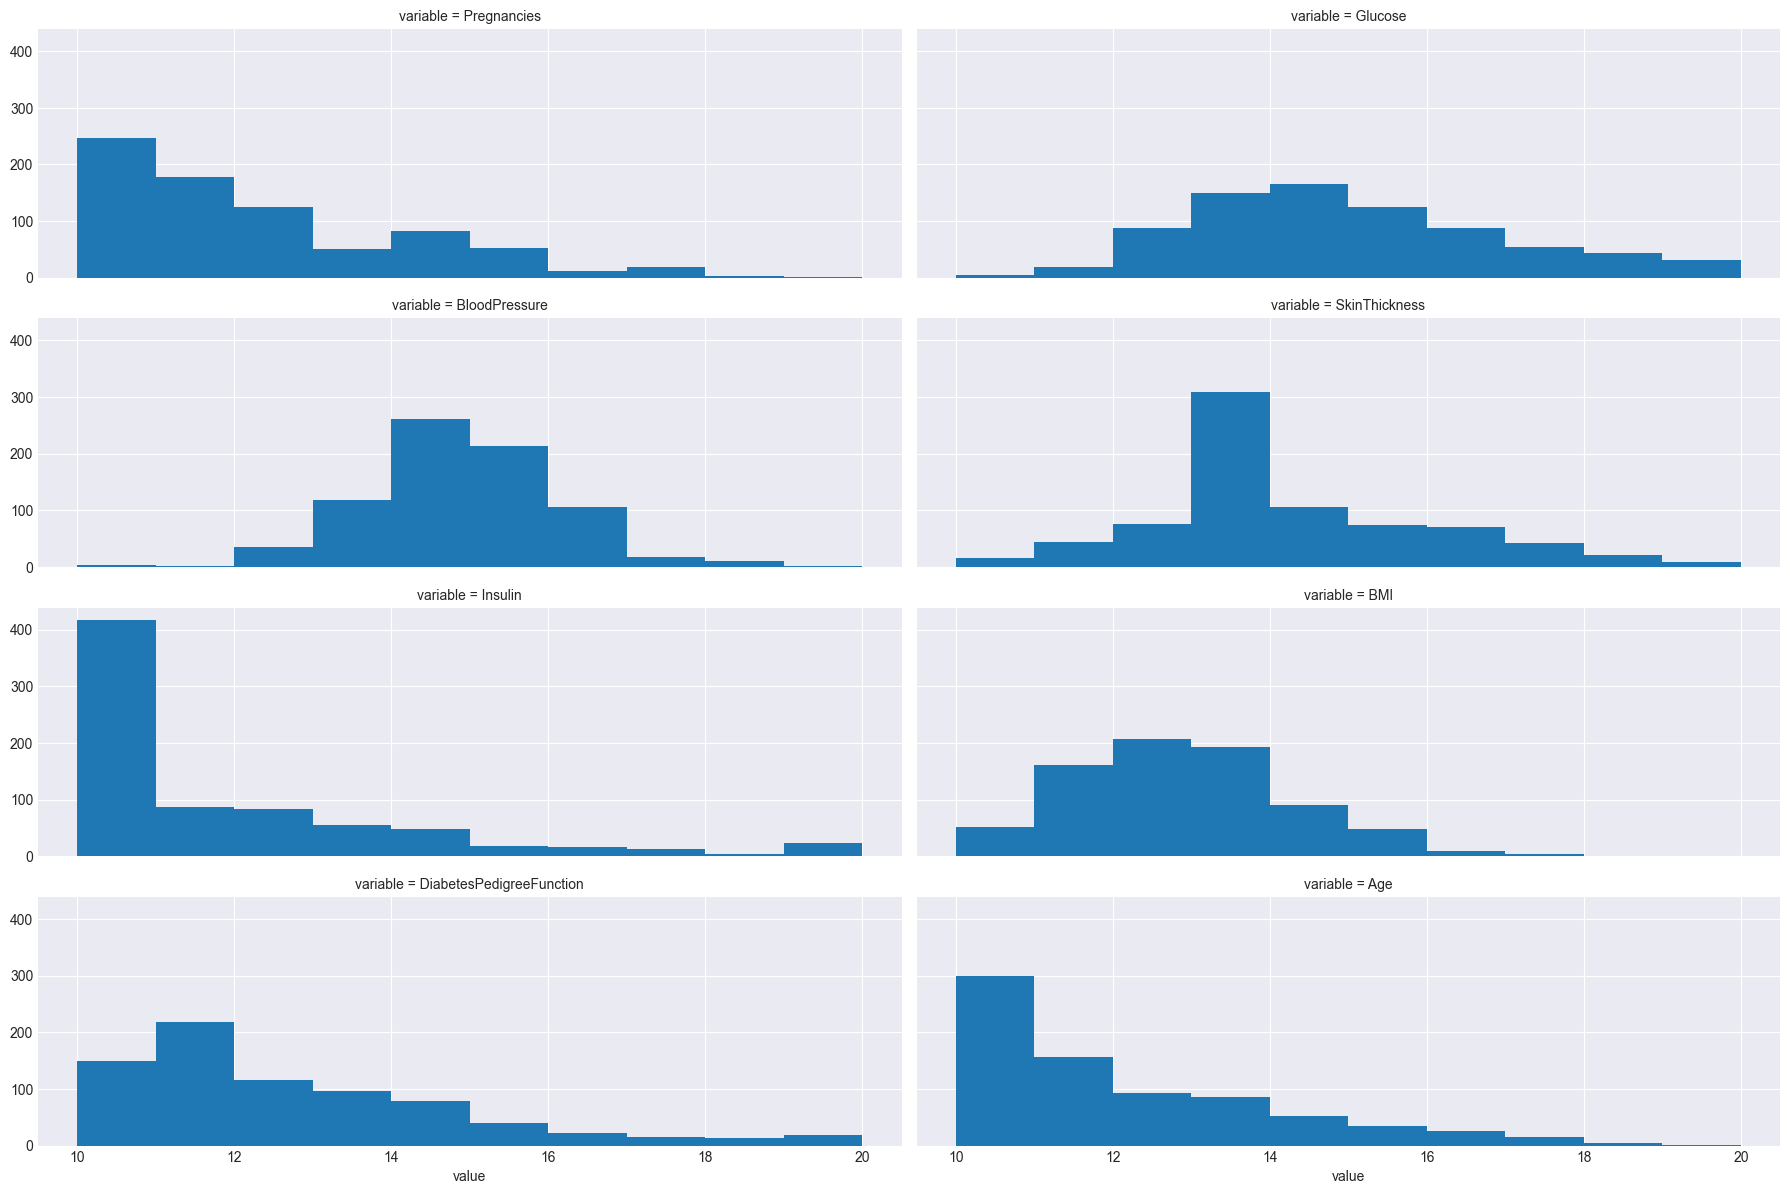

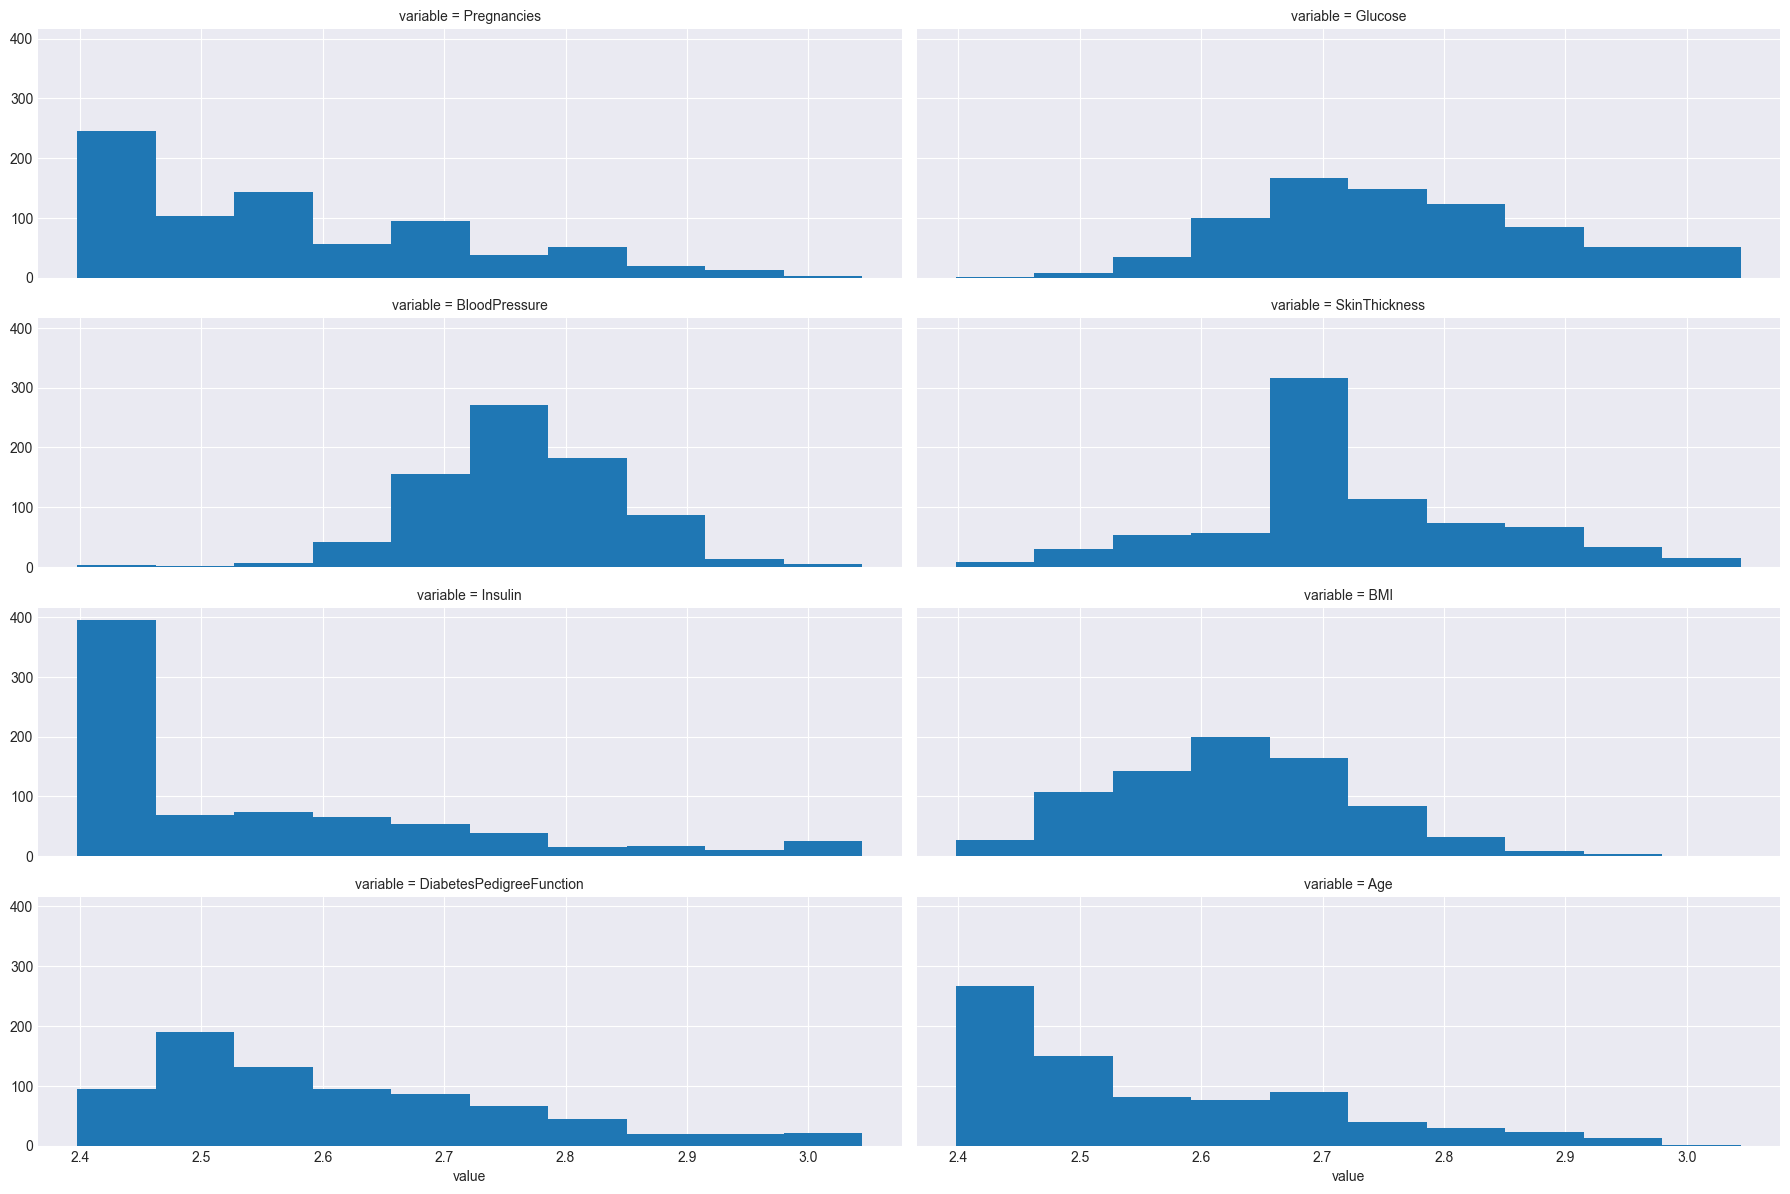

GNB
train score:  0.7465277777777778
test score:  0.765625
cross validation f1 score: 0.6363185914446715
classification report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       125
           1       0.68      0.61      0.65        67

    accuracy                           0.77       192
   macro avg       0.74      0.73      0.74       192
weighted avg       0.76      0.77      0.76       192



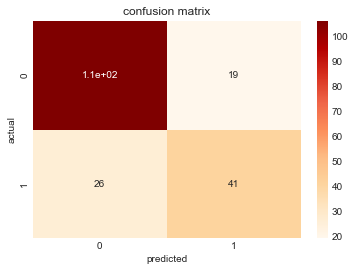

__________________________________________________________________________


In [30]:
SPMP()

pipelines=[]
f1={}

models={'gnb':GaussianNB()}

for name,model in models.items():
    
    # making pipeline for each model
    pipeline = Pipeline(steps=[( "preprocessor", MinMaxScaler() ),
                               ( "classifier", model )
                              ]
                       )
    
    # print name of pipeline
    print(name.upper())
    
    # fitting data
    pipeline.fit(xtrain,ytrain)
    
    # calculating scores and storing
    score_cv=np.mean( cross_val_score(pipeline, X, y, cv=5, scoring='f1', n_jobs=-1) )
    f1[name]=score_cv
    
    # printing scores
    print('train score: ', pipeline.score(xtrain,ytrain) )
    print('test score: ', pipeline.score(xtest,ytest) )
    print('cross validation f1 score:', score_cv)
    print('classification report:\n', classification_report(ytest,pipeline.predict(xtest)) )
    
    #confusion matrix heatmap
    sns.heatmap( confusion_matrix(ytest,pipeline.predict(xtest)), annot=True, cmap='OrRd' )
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('confusion matrix')
    plt.show()
    
    print('__________________________________________________________________________')
    

In [31]:
df_f1=pd.DataFrame(f1.values(), index=f1.keys(), columns=['f1_score'])
df_f1

,f1_score
gnb,0.636319
